In [1]:
import pandas as pd
from pathlib import Path
import os, glob, json, pathlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from sklearn.cluster import KMeans

In [2]:
# 1. Find Paths
cfg_dir = r"C:\Users\brian\OneDrive\Desktop\sports"
os.environ["KAGGLE_CONFIG_DIR"] = cfg_dir

!kaggle --version
!kaggle competitions files -c nfl-big-data-bowl-2026-analytics
!kaggle competitions download -c nfl-big-data-bowl-2026-analytics -p data

data_dir = Path("data")
train_path = next(data_dir.glob("*/train"))
supp_file = train_path.parent / "supplementary_data.csv"

Kaggle API 1.7.4.5
Next Page Token = CfDJ8JvX8PYzZ5dKharEO0H57fFyVD2ru9jVQgEMFtL6dgMbxS5OzyS1r2A3C6MOb2RK21q9xPWvq8SrxgDeJ2Hx6TP3fI0cP81BZGwjTieLkbDNVN6uU7sFCl4Fxc_Mz9YsFmCkPvS4BdGTdc63KPW-_QOqxiXy6aDj_0HBPhqGiXb3dCOiTXqp2GwKKDd2dCenFbDK53zp0QUxzmwPWTX00jCyVeESpUN5RVj8sA
name                                                                                    size  creationDate                
--------------------------------------------------------------------------------  ----------  --------------------------  
114239_nfl_competition_files_published_analytics_final/supplementary_data.csv        7763752  2025-09-23 18:36:30.567000  
114239_nfl_competition_files_published_analytics_final/train/input_2023_w01.csv     48950314  2025-09-23 18:36:32.262000  
114239_nfl_competition_files_published_analytics_final/train/input_2023_w02.csv     49485029  2025-09-23 18:36:32.909000  
114239_nfl_competition_files_published_analytics_final/train/input_2023_w03.csv     51062128  2025-09-23 18:36:32

In [3]:
# 2. Load Supplementary Data
supp_df = pd.read_csv(supp_file, low_memory = False)

In [4]:
# 3. Load All Input Files
input_files = sorted(train_path.glob("input_2023_w*.csv"))

input_dfs = []
for f in input_files:
    df = pd.read_csv(f)
    input_dfs.append(df)

tracking_inputs = pd.concat(input_dfs, ignore_index=True)

In [5]:
# 4. Load All Output Files
output_files = sorted(train_path.glob("output_2023_w*.csv"))

output_dfs = []
for f in output_files:
    df = pd.read_csv(f)
    output_dfs.append(df)

    
tracking_outputs = pd.concat(output_dfs, ignore_index=True)

In [6]:
# 5. Merge Input and Output on Frame Keys
tracking_inputs = tracking_inputs.rename(columns={'x': 'x_in', 'y': 'y_in'})
tracking_outputs = tracking_outputs.rename(columns={'x': 'x_out', 'y': 'y_out'})

tracking = tracking_inputs.merge(
    tracking_outputs,
    on=['game_id', 'play_id', 'nfl_id', 'frame_id'],
    how='outer',
    sort=True
)

tracking['x_full'] = tracking['x_in'].fillna(tracking['x_out'])
tracking['y_full'] = tracking['y_in'].fillna(tracking['y_out'])


In [7]:
# 6. Merge Supplementary Data on game_id and play_id
data = tracking.merge(
    supp_df,
    on=['game_id', 'play_id'],
    how='left'
)

In [8]:
print("Final Shape:", data.shape)
data.head()

Final Shape: (4883089, 66)


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,team_coverage_type,penalty_yards,pre_penalty_yards_gained,yards_gained,expected_points,expected_points_added,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,home_team_win_probability_added,visitor_team_win_probility_added
0,2023090700,101,False,43290,1,right,42.0,Jared Goff,6-4,223.0,...,COVER_2_ZONE,NaN,0,0,0.927021,-2.145443,0.590426,0.409574,0.04972,-0.04972
1,2023090700,101,False,43290,2,right,42.0,Jared Goff,6-4,223.0,...,COVER_2_ZONE,NaN,0,0,0.927021,-2.145443,0.590426,0.409574,0.04972,-0.04972
2,2023090700,101,False,43290,3,right,42.0,Jared Goff,6-4,223.0,...,COVER_2_ZONE,NaN,0,0,0.927021,-2.145443,0.590426,0.409574,0.04972,-0.04972
3,2023090700,101,False,43290,4,right,42.0,Jared Goff,6-4,223.0,...,COVER_2_ZONE,NaN,0,0,0.927021,-2.145443,0.590426,0.409574,0.04972,-0.04972
4,2023090700,101,False,43290,5,right,42.0,Jared Goff,6-4,223.0,...,COVER_2_ZONE,NaN,0,0,0.927021,-2.145443,0.590426,0.409574,0.04972,-0.04972


In [9]:
# 7. Extract Target Receivers
for df in [data]:
    for k in ["game_id", "play_id"]:
        if k in df.columns:
            df[k] = pd.to_numeric(df[k], errors="coerce").astype("Int64")

target_df = data[
    (data['player_role'] == 'Targeted Receiver') &
    (data['player_position'] != 'RB') &
    (data['pass_result'] == 'C')
].copy()

print("Targeted receiver frames:", len(target_df))

Targeted receiver frames: 219651


In [10]:
# 8. Extract Receiver Routes
def extract_route(df):
    routes = []
    for (g,p,n), grp in df.groupby(['game_id','play_id','nfl_id']):
        grp = grp.sort_values('frame_id')
        xy = grp[['x_full','y_full']].dropna().values
        if len(xy) > 10:
            routes.append({
                'game_id': g, 
                'play_id': p, 
                'nfl_id': n,
                'xy': xy,
                'possession_team': grp['possession_team'].iloc[0]
            })
    return routes

routes = extract_route(target_df)
print(f"Extracted {len(routes)} receiver routes.")


Extracted 8030 receiver routes.


In [11]:
# 9. Standardize Player Routes
def resample_route_safe(xy, L=50):
    xy = np.asarray(xy)

    if len(xy) < 2:
        return np.repeat(xy, L, axis=0)

    xy = xy[~np.isnan(xy).any(axis=1)]
    if len(xy) < 2:
        return np.zeros((L, 2))

    t = np.linspace(0, 1, len(xy))
    f_x = interp1d(t, xy[:,0], kind='linear', fill_value='extrapolate')
    f_y = interp1d(t, xy[:,1], kind='linear', fill_value='extrapolate')
    t_new = np.linspace(0, 1, L)

    return np.stack([f_x(t_new), f_y(t_new)], axis=1)

routes = [dict(r, xy=resample_route_safe(r['xy'], 50)) for r in routes]


X = np.array([r['xy'].flatten() for r in routes])

mask = np.isfinite(X).all(axis=1)
X_clean = X[mask]
routes_clean = [routes[i] for i in range(len(routes)) if mask[i]]

kmeans = KMeans(n_clusters=8, random_state=42)
labels = kmeans.fit_predict(X)

for i, r in enumerate(routes):
    r['cluster'] = labels[i]

Enter Team Abbreviation (e.g., 'KC', 'BUF', 'PHI'): ATL


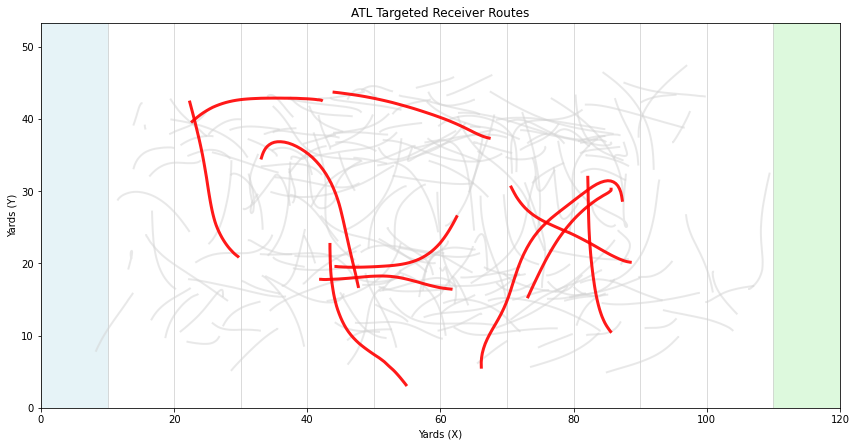

In [12]:
# 10. Plot Receiver Routes by Team
def draw_field(ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,6.3))
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 160/3)

    for x in range(0, 120, 10):
        ax.plot([x, x], [0, 160/3], color='lightgray', lw=0.8)

    ax.axvspan(0, 10, color='lightblue', alpha=0.3)
    ax.axvspan(110, 120, color='lightgreen', alpha=0.3)

    ax.set_xlabel('Yards (X)')
    ax.set_ylabel('Yards (Y)')
    ax.set_title(f'{team_to_plot} Targeted Receiver Routes')
    return ax


def route_length(xy):
    diffs = np.diff(xy, axis=0)
    return np.sum(np.sqrt((diffs**2).sum(axis=1)))


team_to_plot = input("Enter Team Abbreviation (e.g., 'KC', 'BUF', 'PHI'): ").upper()
routes_team = [r for r in routes if r.get("possession_team") == team_to_plot]

if len(routes_team) == 0:
    print(f"No routes found for team {team_to_plot}.")
else:

    routes_to_plot = routes_team

    lengths = np.array([route_length(r['xy']) for r in routes_to_plot])
    cutoff = np.percentile(lengths, 95)

    long_idx = lengths >= cutoff
    normal_idx = lengths < cutoff

    fig, ax = plt.subplots(figsize=(12, 6.3))
    draw_field(ax)

    for r in np.array(routes_to_plot)[normal_idx]:
        xy = r['xy']
        ax.plot(xy[:, 0], xy[:, 1], color="lightgrey", alpha=0.5, lw=2)

# Longest 5% highlighted
    for r in np.array(routes_to_plot)[long_idx]:
        xy = r['xy']
        ax.plot(xy[:, 0], xy[:, 1], color="red", alpha=0.9, lw=3)

plt.tight_layout()
plt.show()


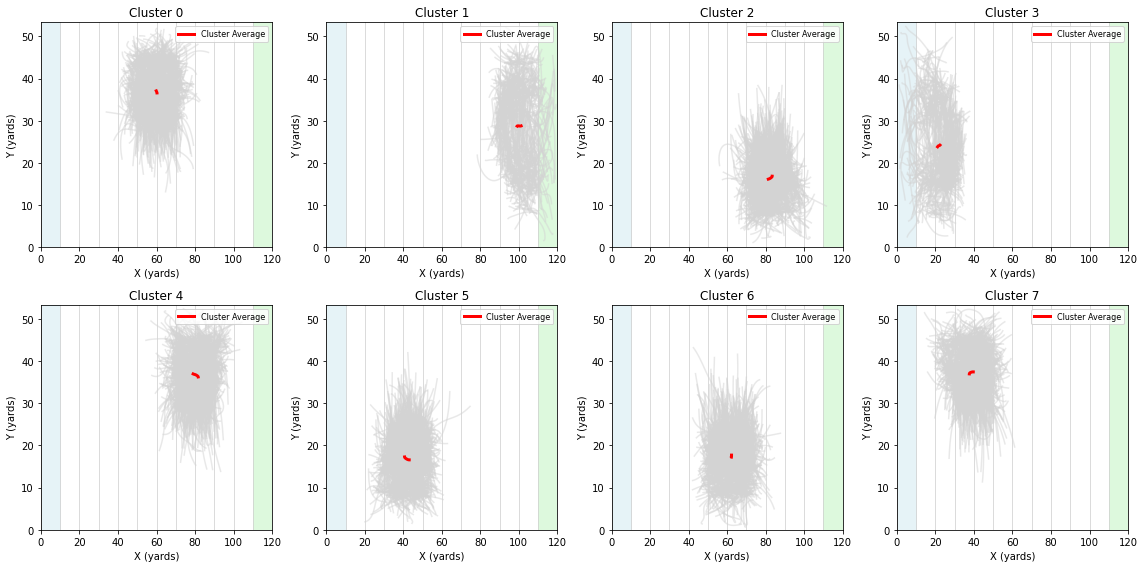

In [13]:
# 11. Plot Receiver Routes by Location Cluster
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for c in range(8):
    ax = axes[c]
    draw_field(ax)
    
    group = [r['xy'] for r in routes if r['cluster']==c]
    if not group:
        ax.set_visible(False)
        continue
    
    for xy in group:
        ax.plot(xy[:,0], xy[:,1], color='lightgrey', alpha=0.5, lw=1.5)
    
    avg = np.mean(np.stack(group), axis=0)
    ax.plot(avg[:,0], avg[:,1], color='red', lw=3, label='Cluster Average')
    
    ax.set_title(f"Cluster {c}")
    ax.set_xlabel('X (yards)')
    ax.set_ylabel('Y (yards)')
    ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

In [14]:
# 12. Calculate Throw Distance
first_positions = (
    target_df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])
             .groupby(['game_id', 'play_id', 'nfl_id'])
             .first()[['x_full', 'y_full']]
             .rename(columns={'x_full': 'x_start', 'y_full': 'y_start'})
             .reset_index()   # <-- add this
)

for col in ['game_id','play_id','nfl_id']:
    target_df[col] = pd.to_numeric(target_df[col], errors='coerce').astype('Int64')
    first_positions[col] = pd.to_numeric(first_positions[col], errors='coerce').astype('Int64')

# Merge starting positions onto target_df
target_df = target_df.merge(
    first_positions,
    on=['game_id', 'play_id', 'nfl_id'],
    how='left'
)

# Now compute throw distance
target_df['throw_distance'] = np.sqrt(
    (target_df['ball_land_x'] - target_df['x_start'])**2 +
    (target_df['ball_land_y'] - target_df['y_start'])**2
)



Average Throw Distance + Start Location by Cluster:
   cluster       mean       std  count      x_full     y_full
0        6  14.849410  8.796529   1111   62.166145  17.681986
1        0  14.229439  7.945591   1111   60.087296  36.536427
2        4  14.226210  8.148110   1126   80.427821  36.333751
3        5  14.092677  8.150808   1164   41.752141  17.293715
4        2  13.919894  8.146524   1140   82.517120  16.742187
5        7  13.545139  7.920905   1145   38.534621  37.017521
6        1  13.414699  6.972211    615  100.321289  28.578422
7        3  12.860438  6.747735    618   21.702713  24.270176


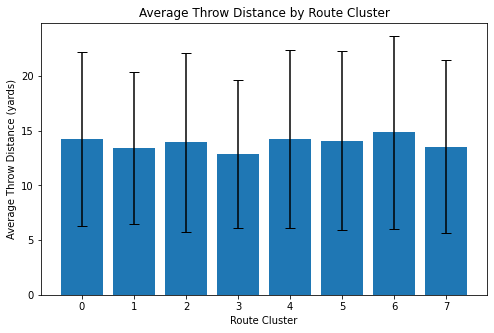

In [15]:
# 13. Extract and Visualize Cluster Information from Routes
clusters_df = pd.DataFrame([{
    'game_id': r['game_id'],
    'play_id': r['play_id'],
    'cluster': r['cluster']
} for r in routes])
target_df_clustered = target_df.merge(clusters_df, on=['game_id', 'play_id'], how='left')

route_summary = []
for r in routes:
    g, p = r['game_id'], r['play_id']
    dist = target_df.loc[
        (target_df['game_id'] == g) & (target_df['play_id'] == p),
        'throw_distance'
    ].mean()
    route_summary.append({
        'game_id': g,
        'play_id': p,
        'cluster': r['cluster'],
        'throw_distance': dist
    })

route_summary_df = pd.DataFrame(route_summary)

avg_throw_by_cluster = (
    route_summary_df.groupby('cluster')['throw_distance']
    .agg(['mean', 'std', 'count'])
    .reset_index()
    .sort_values('mean', ascending=False)
)

avg_start_xy = (
    target_df_clustered.groupby('cluster')[['x_full', 'y_full']]
    .mean()
    .reset_index()
)
avg_throw_by_cluster = avg_throw_by_cluster.merge(avg_start_xy, on='cluster', how='left')

print("\nAverage Throw Distance + Start Location by Cluster:")
print(avg_throw_by_cluster)

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(avg_throw_by_cluster['cluster'], avg_throw_by_cluster['mean'], yerr=avg_throw_by_cluster['std'], capsize=5)
ax.set_xlabel('Route Cluster')
ax.set_ylabel('Average Throw Distance (yards)')
ax.set_title('Average Throw Distance by Route Cluster')
plt.show()


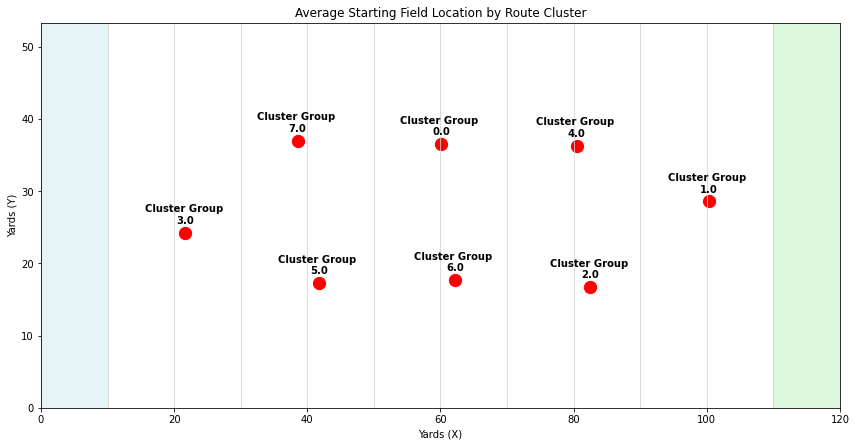

In [16]:
# 14. Visualize Average Starting Point for Each Cluster
fig, ax = plt.subplots(figsize=(12, 6.3))
draw_field(ax)

for _, row in avg_throw_by_cluster.iterrows():
    cx, cy = row['x_full'], row['y_full']
    cluster_id = row['cluster']
    throw_mean = row['mean']

    ax.scatter(cx, cy, s=150, color='red')

    ax.text(
        cx, cy + 1,
        f"Cluster Group \n{cluster_id}",
        ha='center', va='bottom', fontsize=10, weight='bold'
    )

ax.set_title("Average Starting Field Location by Route Cluster")
plt.tight_layout()
plt.show()


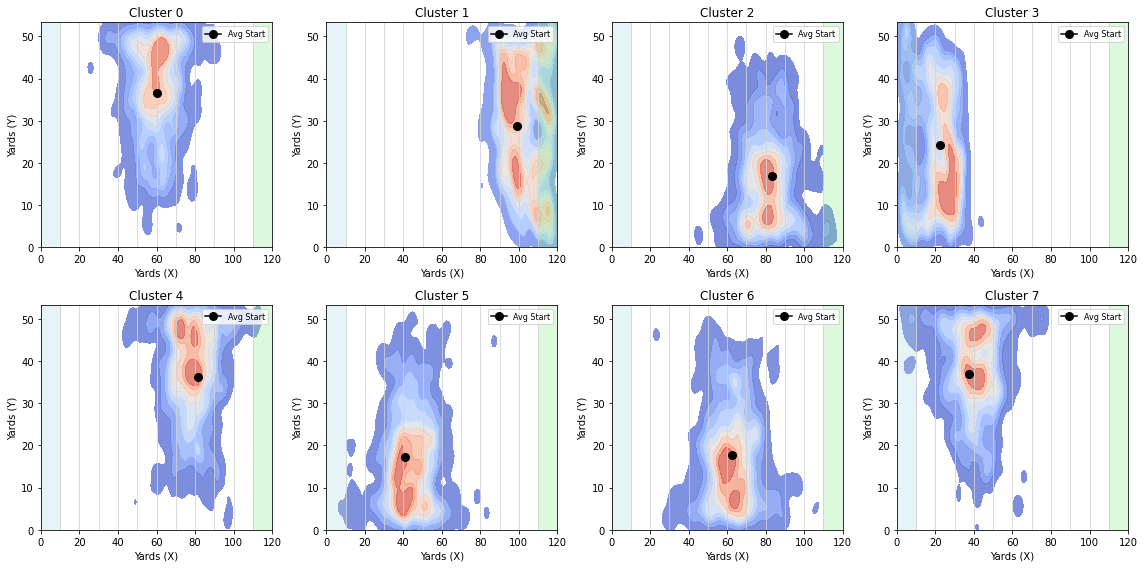

In [17]:
# 15. Create Heatmap Subplots of Each Cluster 
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for c in range(8):
    ax = axes[c]
    
    cluster_routes = [r for r in routes if r['cluster'] == c]
    
    if not cluster_routes:
        ax.set_visible(False)
        continue
    
    cluster_ids = [(r['game_id'], r['play_id']) for r in cluster_routes]
    mask = target_df.set_index(['game_id','play_id']).index.isin(cluster_ids)
    cluster_df = target_df[mask]
    
    sns.kdeplot(
        data=cluster_df,
        x='ball_land_x', y='ball_land_y',
        fill=True, cmap='coolwarm',
        alpha=0.7, thresh=0.05,
        ax=ax
    )
    
    draw_field(ax)
    
    avg_start_x = np.mean([r['xy'][0,0] for r in cluster_routes])
    avg_start_y = np.mean([r['xy'][0,1] for r in cluster_routes])
    ax.plot(avg_start_x, avg_start_y, marker='o', color='black', markersize=8, label='Avg Start')
    
    ax.set_title(f"Cluster {c}")
    ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()